# Predicting Opioid Prescribers

In [21]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import re
from sklearn import metrics
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split



## Introduction

For my capstone project, I’ve decided to tackle the major issue that is the opioid crisis in America. Right now, America faces an average of 115 opioid overdose deaths each day. Over 270 million prescriptions were written in 2012 alone and are a big contributing factor to this issue. As data scientists, we can’t really question whether doctors are pushing prescriptions from sponsorship from pharmaceutical companies, or if they are constantly barraged by patients claiming they are in severe pain and actually need the medication, or really, most other factors for that matter. So, what I wanted to do was try and find the likelihood that a provider would prescribe an opioid and identify any patterns, if any, from that data.

In [3]:
# Importing in the data 

prescribers = pd.read_csv('prescriber-info.csv')

## Feature Selection

Here I am just redoing what I did in previous notebooks because I ran into problems with my data at some point. 

In [5]:
# Grouping by specialty 

specialty = pd.DataFrame(prescribers.groupby(['Specialty']).count()['NPI']).sort_values('NPI')


In [11]:
# Grouping by other/rare specialty

other_specialty = list(specialty.loc[specialty['NPI']<40].index)


In [12]:
# Grouping by Credentials 

credentials = pd.DataFrame(prescribers.groupby(['Credentials']).count()['NPI']).reset_index(False)

In [13]:
# Dropping both NPI and Credentials since they are redudent. 

prescribers_new = prescribers.drop( ['NPI','Credentials'], axis=1)


In [15]:
# Dummying gender, specialty and state for multicollinearity issues. 

prescribers_new = pd.get_dummies(prescribersData, columns=['Gender','Specialty','State'], drop_first=True)

## Modeling

In [18]:
# Assigning X, y variables 
# The target here is Opioid.Prescriber since we are trying to find liklihood of opioids prescribed.

X = prescribers_new.drop(['Opioid.Prescriber'],axis=1).values.astype(float)
y = prescribers_new['Opioid.Prescriber'].values

In [22]:
# Train / Test Split 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [23]:
# Logistic Regression 

# Set up pipeline 
ss = StandardScaler()
logreg = LogisticRegression()
pipes = Pipeline([('ss', ss), ('logreg', logreg)])

# Fit pipeline 
pipes.fit(X_train, y_train)
print(pipes.score(X_test, y_test))
print(pipes.score(X_train, y_train))

0.912
0.9236571428571428


#### Logistic Regression performing 91%

In [24]:
# KNN 

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
print(knn.score(X_test, y_test)) 
print(knn.score(X_train, y_train))

0.8632
0.9007428571428572


#### KNN performing at 86%

In [25]:
# Decision Tree 

decisiontree = DecisionTreeClassifier()
model = decisiontree.fit(X_train, y_train)
print(model.score(X_test, y_test))
print(model.score(X_train, y_train))

0.8986666666666666
0.9984


#### Decision Trees Performing at 89%

In [26]:
# Bagged Decision

bagging = BaggingClassifier()
bagging.fit(X_train, y_train)
print(bagging.score(X_test, y_test))
print(bagging.score(X_train, y_train))

0.9186666666666666
0.9895428571428572


#### Bagged Decision Trees Performing at 91%

In [27]:
# Random Forest

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
print(rf.score(X_test, y_test))
print(rf.score(X_train, y_train))

0.9169333333333334
0.9923428571428572


#### Random Forest performing at 91%

In [28]:
# Adaboost

abr = AdaBoostClassifier()
abr.fit(X_train, y_train)
print(abr.score(X_test, y_test))
print(abr.score(X_train, y_train))

# This model is overfitting, I think 

0.9268
0.9299428571428572


#### Adaboost looks like it may be overfitting 

## Evaluating models using f1 score

In [ ]:
# Defining f1-score function

def f1(model, X, y):
    y_pred = model.predict(X)
    f1 = metrics.f1_score(y, y_pred) 
    return f1

In [ ]:
# Logistic Regression Evaluation

f1(pipes, X_test, y_test), f1(pipes, X_train, y_train)

In [ ]:
# KNN Evaluation 

f1(knn, X_test, y_test), f1(knn, X_train, y_train)

In [ ]:
# Decision Tree Evaluation

f1(decisiontree, X_test, y_test), f1(decisiontree, X_train, y_train)

In [ ]:
# Bagged Tree Evaluation 

f1(bagging, X_test, y_test), f1(bagging, X_train, y_train)

In [ ]:
# Random Forest Evaluation 

f1(rf, X_test, y_test), f1(rf, X_train, y_train)

In [ ]:
# ADA Evaluation

f1(abr, X_test, y_test), f1(abr, X_train, y_train)

## Nueral Network with Cross Validation 

Thanks to Abhijay Ghildyal for a lot of the NN code here, I just had to change some parameters to get better results. 

In [30]:
# Encoding class values as integers 

encoder = LabelEncoder()
encoder.fit(y)
encoded_y = encoder.transform(y)

In [33]:
# Creating baseline for model

def create_baseline():
    # Build model 
    model = Sequential()
    model.add(Dense(60, input_dim = 415, kernel_initializer= 'normal', activation = 'relu'))
    model.add(Dense(1, kernel_initializer = 'normal', activation = 'sigmoid'))
    
    # Compile Model
    
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model

In [34]:
# Evaluating model with the standardized dataset 

estimator = KerasClassifier(build_fn = create_baseline, nb_epoch = 100, batch_size = 5, verbose = 1)
kfold = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)
results = cross_val_score(estimator, X, encoded_y, cv = kfold)
print("Results: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))


Epoch 1/1
2501/2501 [==============================] - 0s 192us/step
Epoch 1/1
2501/2501 [==============================] - 1s 205us/step
Epoch 1/1
2500/2500 [==============================] - 1s 204us/step
Epoch 1/1
2500/2500 [==============================] - 1s 204us/step
Epoch 1/1
2500/2500 [==============================] - 0s 191us/step
Epoch 1/1
2500/2500 [==============================] - 1s 219us/step
Epoch 1/1
2500/2500 [==============================] - 1s 230us/step
Epoch 1/1
2500/2500 [==============================] - 0s 198us/step
Epoch 1/1
2499/2499 [==============================] - 0s 194us/step
Epoch 1/1
2499/2499 [==============================] - 1s 306us/step
Results: 91.26% (0.88%)


In [35]:
# Evaluate baseline model with standardized dataset (This model takes a long time!!!) 

estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=create_baseline, epochs = 20, batch_size = 5, verbose = 2)))
pipeline = Pipeline(estimators)
kfold = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)
results = cross_val_score(pipeline, X, y, cv = kfold)
print("Standardized: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Epoch 1/20
 - 8s - loss: 0.3757 - acc: 0.8259
Epoch 2/20
 - 8s - loss: 0.2976 - acc: 0.8696
Epoch 3/20
 - 8s - loss: 0.2622 - acc: 0.8857
Epoch 4/20
 - 8s - loss: 0.2378 - acc: 0.8975
Epoch 5/20
 - 8s - loss: 0.2210 - acc: 0.9056
Epoch 6/20
 - 9s - loss: 0.2064 - acc: 0.9141
Epoch 7/20
 - 8s - loss: 0.1957 - acc: 0.9192
Epoch 8/20
 - 8s - loss: 0.1852 - acc: 0.9241
Epoch 9/20
 - 8s - loss: 0.1779 - acc: 0.9271
Epoch 10/20
 - 8s - loss: 0.1720 - acc: 0.9309
Epoch 11/20
 - 8s - loss: 0.1658 - acc: 0.9336
Epoch 12/20
 - 8s - loss: 0.1584 - acc: 0.9361
Epoch 13/20
 - 7s - loss: 0.1542 - acc: 0.9372
Epoch 14/20
 - 7s - loss: 0.1514 - acc: 0.9414
Epoch 15/20
 - 7s - loss: 0.1461 - acc: 0.9428
Epoch 16/20
 - 8s - loss: 0.1401 - acc: 0.9442
Epoch 17/20
 - 9s - loss: 0.1395 - acc: 0.9451
Epoch 18/20
 - 8s - loss: 0.1330 - acc: 0.9483
Epoch 19/20
 - 7s - loss: 0.1284 - acc: 0.9505
Epoch 20/20
 - 7s - loss: 0.1297 - acc: 0.9507
Epoch 1/20
 - 7s - loss: 0.3727 - acc: 0.8290
Epoch 2/20
 - 7s - loss

Epoch 17/20
 - 7s - loss: 0.1410 - acc: 0.9444
Epoch 18/20
 - 8s - loss: 0.1350 - acc: 0.9468
Epoch 19/20
 - 9s - loss: 0.1343 - acc: 0.9480
Epoch 20/20
 - 8s - loss: 0.1297 - acc: 0.9499
Epoch 1/20
 - 9s - loss: 0.3729 - acc: 0.8300
Epoch 2/20
 - 8s - loss: 0.2964 - acc: 0.8705
Epoch 3/20
 - 8s - loss: 0.2618 - acc: 0.8858
Epoch 4/20
 - 9s - loss: 0.2386 - acc: 0.8987
Epoch 5/20
 - 9s - loss: 0.2238 - acc: 0.9059
Epoch 6/20
 - 9s - loss: 0.2097 - acc: 0.9115
Epoch 7/20
 - 8s - loss: 0.1980 - acc: 0.9185
Epoch 8/20
 - 8s - loss: 0.1892 - acc: 0.9223
Epoch 9/20
 - 9s - loss: 0.1777 - acc: 0.9292
Epoch 10/20
 - 9s - loss: 0.1707 - acc: 0.9308
Epoch 11/20
 - 9s - loss: 0.1656 - acc: 0.9330
Epoch 12/20
 - 9s - loss: 0.1589 - acc: 0.9356
Epoch 13/20
 - 8s - loss: 0.1554 - acc: 0.9383
Epoch 14/20
 - 9s - loss: 0.1516 - acc: 0.9409
Epoch 15/20
 - 9s - loss: 0.1461 - acc: 0.9423
Epoch 16/20
 - 9s - loss: 0.1432 - acc: 0.9446
Epoch 17/20
 - 7s - loss: 0.1361 - acc: 0.9478
Epoch 18/20
 - 7s - lo

In [36]:
print("On cross validation model gives accuracy of: %.2f%% with a std of (%.2f%%)" % (results.mean()*100, results.std()*100))

On cross validation model gives accuracy of: 88.98% with a std of (0.66%)


## Final NN Model and Results 

In [39]:
model = Sequential()
model.add(Dense(60, input_dim = 415, kernel_initializer = 'normal', activation = 'relu'))
model.add(Dense(1, kernel_initializer = 'normal', activation = 'sigmoid'))

# Compiling Model 

earlystop = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 2, verbose = 0, mode = 'auto')
callbacks_list = [earlystop]
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])


In [40]:
history = model.fit(X, y, validation_split = 0.1, epochs = 20, batch_size = 5, verbose = 2, callbacks = callbacks_list)

Train on 22500 samples, validate on 2500 samples
Epoch 1/20
 - 9s - loss: 0.3335 - acc: 0.8998 - val_loss: 0.2303 - val_acc: 0.9120
Epoch 2/20
 - 8s - loss: 0.2381 - acc: 0.9174 - val_loss: 0.2353 - val_acc: 0.9128
Epoch 3/20
 - 8s - loss: 0.2181 - acc: 0.9204 - val_loss: 0.2588 - val_acc: 0.9060


In [41]:
loss, accuracy = model.evaluate(X, y)

25000/25000 [==============================] - 1s 38us/step


In [42]:
accuracy

0.91496

In [43]:
loss

0.22768271602392195

## Standardizing/Fitting Model

In [44]:
min_max_scaler = preprocessing.MinMaxScaler()
x_minmax = min_max_scaler.fit_transform(X)
X_test_minmax = min_max_scaler.transform(X_test)

scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [45]:
history = model.fit(X_scaled, y, validation_split = 0.25, epochs = 20, batch_size = 5, verbose = 2, callbacks = callbacks_list)

Train on 18750 samples, validate on 6250 samples
Epoch 1/20
 - 7s - loss: 0.3853 - acc: 0.8212 - val_loss: 0.3597 - val_acc: 0.8338
Epoch 2/20
 - 7s - loss: 0.3075 - acc: 0.8622 - val_loss: 0.3337 - val_acc: 0.8595
Epoch 3/20
 - 7s - loss: 0.2707 - acc: 0.8840 - val_loss: 0.3279 - val_acc: 0.8693
Epoch 4/20
 - 7s - loss: 0.2461 - acc: 0.8966 - val_loss: 0.2988 - val_acc: 0.8830
Epoch 5/20
 - 7s - loss: 0.2256 - acc: 0.9064 - val_loss: 0.3037 - val_acc: 0.8838
Epoch 6/20
 - 7s - loss: 0.2107 - acc: 0.9137 - val_loss: 0.3105 - val_acc: 0.8872


In [46]:
loss, accuracy = model.evaluate(X_scaled, y)

25000/25000 [==============================] - 1s 38us/step


In [47]:
accuracy

0.91716

In [48]:
loss

0.21478672669887544

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


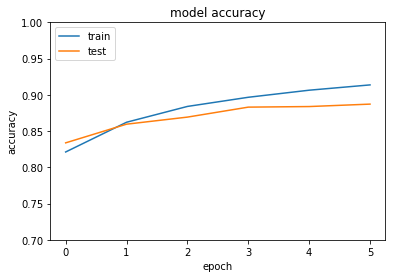

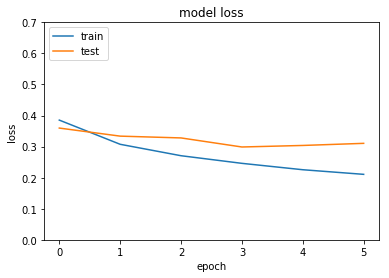

In [49]:
# Thanks Abhijay Ghildyal for this plot, too 
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim(0.7,1)
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim(0,0.7)
plt.legend(['train', 'test'], loc='upper left')
plt.show()